In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import torch 
import pandas as pd
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
tf.debugging.set_log_device_placement(False)
random.seed(9)

In [2]:
os.listdir("/kaggle/input/porn-nonporn-detection/rnn_modelling_data/extracted_frame_features")

['train', 'val', 'test']

In [3]:
path = "/kaggle/input/porn-nonporn-detection/rnn_modelling_data/extracted_frame_features"

In [4]:
save_path = "/kaggle/input/rnn_modelling_data"

In [5]:
train_data = os.path.join(path,"train")
test_data = os.path.join(path,"test")
val_data = os.path.join(path,"val")

In [6]:
class datagen:
    def __init__(self,train_data_path,val_data_path,test_data_path):
        self.train_data_path = train_data_path
        self.val_data_path = val_data_path
        self.test_data_path = test_data_path
        self.batch_size = 16
        self.seq_len =8
        
    def val_videos_xy(self):
        porn_add = os.path.join(self.val_data_path,"porn")
        non_porn_add = os.path.join(self.val_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        
        for i in range(100):
            
            if i<50:
                porn_video = porn_list[i]
                porn = torch.load(porn_video)
                key = list(porn.keys())[0]
                porn = porn[key].numpy()
                video_x = []
                for step in range((porn.shape[0]//self.seq_len)-1):
                    video_sample = porn[step:step+self.seq_len]
                    video_x.append(video_sample)
                video_x = np.array(video_x)
                video_x = video_x.reshape((-1,self.seq_len,512))
                video_y = np.ones((video_x.shape[0],))
                yield video_x.reshape((-1,self.seq_len,512,1)),video_y

            elif i>=50:
                non_porn_video = non_porn_list[i%50]
                non_porn = torch.load(non_porn_video)

                key = list(non_porn.keys())[0]
                non_porn = non_porn[key].numpy()

                video_x = []
                for step in range((non_porn.shape[0]//self.seq_len)-1):
                    video_sample = non_porn[step:step+self.seq_len]
                    video_x.append(video_sample)
                video_x = np.array(video_x)
                video_x = video_x.reshape((-1,self.seq_len,512))
                video_y = np.zeros((video_x.shape[0],))
                yield video_x.reshape((-1,self.seq_len,512,1)),video_y

        
        
    def test_videos_xy(self):
        porn_add = os.path.join(self.test_data_path,"porn")
        non_porn_add = os.path.join(self.test_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        
        for i in range(100):
            
            if i<50:
                porn_video = porn_list[i]
                porn = torch.load(porn_video)
                key = list(porn.keys())[0]
                porn = porn[key].numpy()
                video_x = []
                for step in range((porn.shape[0]//self.seq_len)-1):
                    video_sample = porn[step:step+self.seq_len]
                    video_x.append(video_sample)
                video_x = np.array(video_x)
                video_x = video_x.reshape((-1,self.seq_len,512))
                video_y = np.ones((video_x.shape[0],))
                yield video_x.reshape((-1,self.seq_len,512,1)),video_y

            elif i>=50:
                non_porn_video = non_porn_list[i%50]
                non_porn = torch.load(non_porn_video)

                key = list(non_porn.keys())[0]
                non_porn = non_porn[key].numpy()

                video_x = []
                for step in range((non_porn.shape[0]//self.seq_len)-1):
                    video_sample = non_porn[step:step+self.seq_len]
                    video_x.append(video_sample)
                video_x = np.array(video_x)
                video_x = video_x.reshape((-1,self.seq_len,512))
                video_y = np.zeros((video_x.shape[0],))
                yield video_x.reshape((-1,self.seq_len,512,1)),video_y
            
                
                
    def test_gen(self):  
        porn_add = os.path.join(self.test_data_path,"porn")
        non_porn_add = os.path.join(self.test_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        random.shuffle(porn_list)
        random.shuffle(non_porn_list)
        
        # start generating data
        for i in range(50):
            #print(porn_list[i],len(porn_list))
            porn_video = porn_list[i]
            non_porn_video = non_porn_list[i]
            
            porn = torch.load(porn_video)
            non_porn = torch.load(non_porn_video)
            
            key = list(porn.keys())[0]
            porn = porn[key].numpy()
            
            key = list(non_porn.keys())[0]
            non_porn = non_porn[key].numpy()
            
            if porn.shape[0]<= self.seq_len and non_porn.shape[0]<=self.seq_len:
                continue
                
            elif porn.shape[0]<=self.batch_size*self.seq_len and non_porn.shape[0]<self.batch_size*self.seq_len:
                try:
                    temp_batch_size = 8

                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= temp_batch_size)
                    np_choice = random.choices(np_indexes,k= temp_batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],1))
                    y_np = np.zeros((batch_np.shape[0],1))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*temp_batch_size,))
                except: 
                    continue
                
                
            else:
                try:
                    batch_size = self.batch_size
                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= self.batch_size)
                    np_choice = random.choices(np_indexes,k= self.batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],1))
                    y_np = np.zeros((batch_np.shape[0],1))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*self.batch_size,))
                    
                except:
                    continue
        
    def val_gen(self):
        porn_add = os.path.join(self.val_data_path,"porn")
        non_porn_add = os.path.join(self.val_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        random.shuffle(porn_list)
        random.shuffle(non_porn_list)
        
        # start generating data
        for i in range(50):
            #print(porn_list[i],len(porn_list))
            porn_video = porn_list[i]
            non_porn_video = non_porn_list[i]
            
            porn = torch.load(porn_video)
            non_porn = torch.load(non_porn_video)
            
            key = list(porn.keys())[0]
            porn = porn[key].numpy()
            
            key = list(non_porn.keys())[0]
            non_porn = non_porn[key].numpy()
            
            if porn.shape[0]<= self.seq_len and non_porn.shape[0]<=self.seq_len:
                continue
                
            elif porn.shape[0]<=self.batch_size*self.seq_len and non_porn.shape[0]<self.batch_size*self.seq_len:
                try:
                    temp_batch_size = 8

                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= temp_batch_size)
                    np_choice = random.choices(np_indexes,k= temp_batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],1))
                    y_np = np.zeros((batch_np.shape[0],1))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*temp_batch_size,))
                except: 
                    continue
                
                
            else:
                try:
                    batch_size = self.batch_size
                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= self.batch_size)
                    np_choice = random.choices(np_indexes,k= self.batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],1))
                    y_np = np.zeros((batch_np.shape[0],1))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*self.batch_size,))
                    
                except:
                    continue

        
    def train_gen(self):
        porn_add = os.path.join(self.train_data_path,"porn")
        non_porn_add = os.path.join(self.train_data_path,"non_porn")
        porn_list = os.listdir(porn_add)
        non_porn_list  = os.listdir(non_porn_add)
        porn_list = [os.path.join(porn_add,x) for x in porn_list]
        non_porn_list= [os.path.join(non_porn_add,x) for x in non_porn_list]
        self.error_count = 0
        random.shuffle(porn_list)
        random.shuffle(non_porn_list)
        
        # start generating data
        for i in range(300):
        
            porn_video = porn_list[i]
            non_porn_video = non_porn_list[i]
            
            porn = torch.load(porn_video)
            non_porn = torch.load(non_porn_video)
            
            key = list(porn.keys())[0]
            porn = porn[key].numpy()
            
            key = list(non_porn.keys())[0]
            non_porn = non_porn[key].numpy()
            
            if porn.shape[0]<= self.seq_len and non_porn.shape[0]<=self.seq_len:
                continue
                
            elif porn.shape[0]<=self.batch_size*self.seq_len and non_porn.shape[0]< self.batch_size*self.seq_len :
                try:
                    temp_batch_size = 8

                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= temp_batch_size)
                    np_choice = random.choices(np_indexes,k= temp_batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],))
                    y_np = np.zeros((batch_np.shape[0],))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print("ELIF",batch.shape,y.shape)
                
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*temp_batch_size,))
                except:
                    continue
                
                
            else:
                try:
                    batch_size = self.batch_size
                    p_indexes = np.arange(porn.shape[0]-self.seq_len)
                    np_indexes = np.arange(non_porn.shape[0]-self.seq_len)

                    p_choice = random.choices(p_indexes,k= batch_size)
                    np_choice = random.choices(np_indexes,k= batch_size)

                    batch_p = []
                    batch_np = []

                    for t in p_choice:
                        sample_p = porn[t:t+self.seq_len]
                        sample_p = sample_p.reshape((self.seq_len,512))
                        batch_p.append(sample_p)

                    for t in np_choice:
                        sample_np = non_porn[t:t+self.seq_len]
                        sample_np = sample_np.reshape((self.seq_len,512))
                        batch_np.append(sample_np)

                    batch_p = np.array(batch_p)
                    batch_np = np.array(batch_np)

                    batch_p = batch_p.reshape((-1,self.seq_len,512))
                    batch_np = batch_np.reshape((-1,self.seq_len,512))

                    y_p = np.ones((batch_p.shape[0],))
                    y_np = np.zeros((batch_np.shape[0],))

                    batch  = np.r_[batch_p,batch_np]
                    y = np.r_[y_p,y_np]
                    #print(batch.shape,y.shape)
                    yield batch.reshape((-1,self.seq_len,512,1)),y.reshape((2*batch_size,))
                    
                except:
                    continue

            

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(16,(5,5),padding = "same",activation = "relu",input_shape = (8,512,1)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(32,(5,5),padding = "valid",activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64,(3,5),padding = "valid",activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(128,(2,5),padding = "valid",activation = "relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation = "relu"))
model.add(layers.Dense(2,activation= "softmax"))
model.summary()
model.compile( loss = "sparse_categorical_crossentropy",optimizer = "adam")

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 8, 512, 16)        416       
_________________________________________________________________
dropout (Dropout)            (None, 8, 512, 16)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 4, 508, 32)        12832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 508, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 2, 504, 64)        30784     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 504, 64)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 1, 500, 128)     

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(8,(3,3),padding = "valid",activation = "relu",input_shape = (32,512,1)))
model.add(layers.MaxPool2D((2,2),strides = (2,2)))
model.add(layers.Conv2D(16,(3,3),padding  = "valid",activation = "relu"))
model.add(layers.MaxPool2D((2,2),strides = (2,2)))
model.add(layers.Conv2D(32,(3,3),padding  = "valid",activation = "relu"))
model.add(layers.MaxPool2D((2,2),strides = (1,1)))
model.add(layers.Conv2D(64,(3,3),padding  = "valid",activation = "relu"))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation = "relu"))
model.add(layers.Dense(2,activation = "softmax"))
model.summary()
model.compile( loss = "sparse_categorical_crossentropy",optimizer = "adam")

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters = 8,kernel_size = (3,3),padding = "valid",strides = (1,1),activation = "relu",input_shape = (16,512,1)))
model.add(layers.Conv2D(16,(3,3),strides = (1,1),activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(16,(3,3),strides=(1,1),activation = "relu" ))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(32,(3,3),strides = (1,1),activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64,(3,3),strides = (2,2),activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64,(3,3),strides = (2,2),activation = "relu"))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation = "relu"))
model.add(layers.Dense(2,activation = "softmax"))
model.summary()
model.compile( loss = "sparse_categorical_crossentropy",optimizer = "adam")

In [ ]:
layers.Conv2D?

In [ ]:
#Running Model
model = models.Sequential()
model.add(layers.LSTM(512,activation = "relu",input_shape =(16,512)))
#model.add(layers.Dense(64,activation = "relu"))
model.add(layers.Dense(256,activation = "relu"))
#model.add(layers.Dense(64,activation = "relu"))
model.add(layers.Dense(2,activation = "softmax"))
model.summary()
model.compile( loss = "sparse_categorical_crossentropy",optimizer = optimizers.Adam(learning_rate = 0.00003))

In [25]:
gen = datagen(train_data,val_data,test_data)

In [ ]:
for x,y in gen.train_gen():
    print(x.shape,y.shape)

In [9]:
def n_fold_accuracy(model,gen,n_folds = 5,type = "test"):
    ten_fold_accuracy = 0.0  
    ten_fold_loss = 0.0
    n_folds = n_folds
    if type == "test":
        for i in range(n_folds):
            total_samples = 0
            total_correct = 0.0
            running_loss = 0.0
            batch_ = 0
            for x,y in gen.test_gen():
                
                batch_ += 1
                met = model.evaluate(x,y,verbose = 0) #for loss we do this 
                y_pred = model.predict(x)
                y_pred = np.argmax(y_pred,axis = 1)
                total_samples += x.shape[0]
                total_correct += np.sum(y_pred==y)
                running_loss += met*x.shape[0]
                
            accuracy_shown = total_correct/np.float(total_samples)
            ten_fold_accuracy += accuracy_shown
            loss_shown  = running_loss/np.float(total_samples)
            ten_fold_loss += loss_shown
        print("%d Fold Test Accuracy : {%.4f} || %d Fold Test Loss : {%.4f}"%(n_folds,ten_fold_accuracy/np.float(n_folds),n_folds,ten_fold_loss/np.float(n_folds)))
        return ten_fold_accuracy/np.float(n_folds),ten_fold_loss/np.float(n_folds)
    else:
        for i in range(n_folds):
            total_samples = 0
            total_correct = 0.0
            running_loss = 0.0
            batch_ = 0
            for x,y in gen.val_gen():
                batch_ += 1
                met = model.evaluate(x,y,verbose = 0) #for loss we do this 
                y_pred = model.predict(x)
                y_pred = np.argmax(y_pred,axis = 1)
                total_samples += x.shape[0]
                total_correct += np.sum(y_pred==y)
                running_loss += met*x.shape[0]
            accuracy_shown = total_correct/np.float(total_samples)
            ten_fold_accuracy += accuracy_shown
            loss_shown  = running_loss/np.float(total_samples)
            ten_fold_loss += loss_shown
        print("%d Fold Validation Accuracy : {%.4f} || %d Fold Validation Loss : {%.4f}"%(n_folds,ten_fold_accuracy/np.float(n_folds),n_folds,ten_fold_loss/np.float(n_folds)))
        return ten_fold_accuracy/np.float(n_folds),ten_fold_loss/np.float(n_folds)
        

In [10]:
def test_videos_acc(model,gen):
    correct_videos = 0
    total_videos = 0
    number  = 0
    for x,y in gen.test_videos_xy():
        try:
            video_label = y[0]    
            number+=1
            #print(number,"-->",x.shape,y.shape)
            total_samples= 0
            total_correct= 0
            total_videos +=1
            met = model.evaluate(x,y,verbose = 0) #for loss we do this 
            y_pred = model.predict(x)
            label_pred = np.argmax(np.mean(y_pred,axis = 0).reshape((1,2)),axis = 1)
            y_pred = np.argmax(y_pred,axis = 1)
            if label_pred==video_label:
                correct_videos += 1
            total_samples += x.shape[0]
            total_correct += np.sum(y_pred==y)
        except:
            continue
        #print("Video {%d} Sequence Prediction Accuracy {%.4f} Sequence Prediction Loss {%.4f} "%(total_videos,total_correct/np.float(total_samples),met)," Video Final Prediction {}".format(label_pred==video_label))
    print("Total Correct Prediction Percentage {}% ".format((np.float(correct_videos)/np.float(total_videos))*100))
    return (np.float(correct_videos)/np.float(total_videos))*100

In [11]:
def val_videos_acc(model,gen):
    correct_videos = 0
    total_videos = 0
    number  = 0
    for x,y in gen.val_videos_xy():
        try:
            video_label = y[0]    
            number+=1
            #print(number,"-->",x.shape,y.shape)
            total_samples= 0
            total_correct= 0
            total_videos +=1
            met = model.evaluate(x,y,verbose = 0) #for loss we do this 
            y_pred = model.predict(x)
            label_pred = np.argmax(np.mean(y_pred,axis = 0).reshape((1,2)),axis = 1)
            y_pred = np.argmax(y_pred,axis = 1)
            if label_pred==video_label:
                correct_videos += 1
            total_samples += x.shape[0]
            total_correct += np.sum(y_pred==y)
        except:
            continue
        #print("Video {%d} Sequence Prediction Accuracy {%.4f} Sequence Prediction Loss {%.4f} "%(total_videos,total_correct/np.float(total_samples),met)," Video Final Prediction {}".format(label_pred==video_label))
    print("Total Correct Prediction Percentage {}% ".format((np.float(correct_videos)/np.float(total_videos))*100))
    return (np.float(correct_videos)/np.float(total_videos))*100

In [12]:
os.listdir("/kaggle/input/states/state-3")

['validation_accuracy_g_1.npy',
 'best_train_acc.h5',
 'best_classifier.h5',
 'best_val_acc_n.h5',
 'training_loss_g.npy',
 'best_val_acc_1.h5',
 'model_state.npy',
 'validation_loss_g_n.npy',
 'validation_loss_g_1.npy',
 'validation_accuracy_g_n.npy',
 'training_accuracy_g.npy']

In [ ]:
items = os.listdir("/kaggle/input/states/state-3")
retrieve_path = "/kaggle/input/states/state-3/"
model = tf.keras.models.load_model(os.path.join(retrieve_path,"best_train_acc.h5"))
state_dict = np.load(os.path.join(retrieve_path,"model_state.npy"),allow_pickle = True).item()
print(state_dict)

max_train_acc = state_dict["max_acc"]
max_val_acc_1 = state_dict["max_val_acc_1"]
max_val_acc_n = state_dict["max_val_acc_n"]
best_test_class_acc = state_dict["best_test_class_acc"]

training_loss_g= list(np.load(os.path.join(retrieve_path,'training_loss_g.npy'),allow_pickle = True))
training_accuracy_g = list(np.load(os.path.join(retrieve_path,'training_accuracy_g.npy'),allow_pickle = True))
validation_accuracy_g_1 = list(np.load(os.path.join(retrieve_path,'validation_accuracy_g_1.npy'),allow_pickle = True))
validation_accuracy_g_n = list(np.load(os.path.join(retrieve_path,'validation_accuracy_g_n.npy'),allow_pickle = True))
validation_loss_g_1 = list(np.load(os.path.join(retrieve_path,'validation_loss_g_1.npy'),allow_pickle = True))
validation_loss_g_n = list(np.load(os.path.join(retrieve_path,'validation_loss_g_n.npy'),allow_pickle = True))

Epoch 1/450
training loss : {0.6511} training_acc : {0.6245} 
5 Fold Validation Accuracy : {0.6819} || 5 Fold Validation Loss : {0.5735}
1 Fold Validation Accuracy : {0.6925} || 1 Fold Validation Loss : {0.5686}
Total Correct Prediction Percentage 72.0% 
Total Correct Prediction Percentage 67.0% 
5 Fold Test Accuracy : {0.6536} || 5 Fold Test Loss : {0.6221}
1 Fold Test Accuracy : {0.6506} || 1 Fold Test Loss : {0.6240}
Epoch 2/450
training loss : {0.5346} training_acc : {0.7507} 
5 Fold Validation Accuracy : {0.7652} || 5 Fold Validation Loss : {0.4770}
1 Fold Validation Accuracy : {0.7744} || 1 Fold Validation Loss : {0.4646}
Total Correct Prediction Percentage 78.0% 
Total Correct Prediction Percentage 72.0% 
5 Fold Test Accuracy : {0.6913} || 5 Fold Test Loss : {0.5970}
1 Fold Test Accuracy : {0.7003} || 1 Fold Test Loss : {0.6006}
Epoch 3/450
training loss : {0.4989} training_acc : {0.7754} 
5 Fold Validation Accuracy : {0.7863} || 5 Fold Validation Loss : {0.4679}
1 Fold Validati

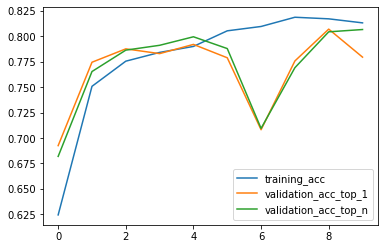

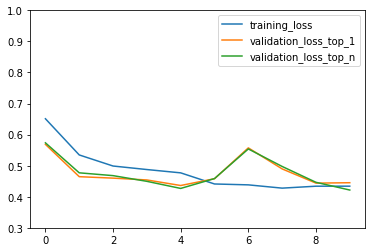

Epoch 11/450
training loss : {0.4273} training_acc : {0.8166} 
5 Fold Validation Accuracy : {0.7991} || 5 Fold Validation Loss : {0.4289}
1 Fold Validation Accuracy : {0.7850} || 1 Fold Validation Loss : {0.4527}
Total Correct Prediction Percentage 81.0% 
Total Correct Prediction Percentage 74.0% 
Epoch 12/450
training loss : {0.4067} training_acc : {0.8264} 
5 Fold Validation Accuracy : {0.8140} || 5 Fold Validation Loss : {0.4268}
1 Fold Validation Accuracy : {0.8200} || 1 Fold Validation Loss : {0.4291}
Total Correct Prediction Percentage 79.0% 
Total Correct Prediction Percentage 68.0% 
Epoch 13/450
training loss : {0.4032} training_acc : {0.8333} 
5 Fold Validation Accuracy : {0.8006} || 5 Fold Validation Loss : {0.4332}
1 Fold Validation Accuracy : {0.7825} || 1 Fold Validation Loss : {0.4373}
Total Correct Prediction Percentage 80.0% 
Total Correct Prediction Percentage 73.0% 
Epoch 14/450
training loss : {0.4096} training_acc : {0.8224} 
5 Fold Validation Accuracy : {0.7266} ||

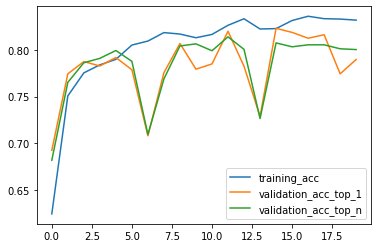

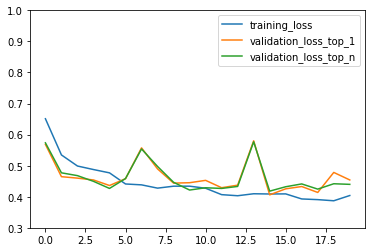

Epoch 21/450
training loss : {0.4016} training_acc : {0.8341} 
5 Fold Validation Accuracy : {0.7976} || 5 Fold Validation Loss : {0.4416}
1 Fold Validation Accuracy : {0.7944} || 1 Fold Validation Loss : {0.4313}
Total Correct Prediction Percentage 82.0% 
Total Correct Prediction Percentage 77.0% 
5 Fold Test Accuracy : {0.7232} || 5 Fold Test Loss : {0.6296}
1 Fold Test Accuracy : {0.6987} || 1 Fold Test Loss : {0.6735}
Epoch 22/450
training loss : {0.3919} training_acc : {0.8355} 
5 Fold Validation Accuracy : {0.8100} || 5 Fold Validation Loss : {0.4139}
1 Fold Validation Accuracy : {0.8019} || 1 Fold Validation Loss : {0.4213}
Total Correct Prediction Percentage 79.0% 
Total Correct Prediction Percentage 73.0% 
Epoch 23/450
training loss : {0.3694} training_acc : {0.8423} 
5 Fold Validation Accuracy : {0.7416} || 5 Fold Validation Loss : {0.5279}
1 Fold Validation Accuracy : {0.7393} || 1 Fold Validation Loss : {0.5165}
Total Correct Prediction Percentage 71.0% 
Total Correct Predic

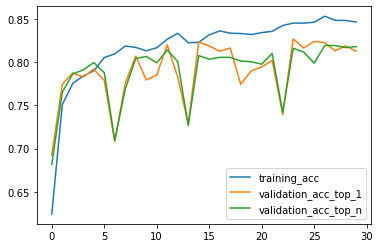

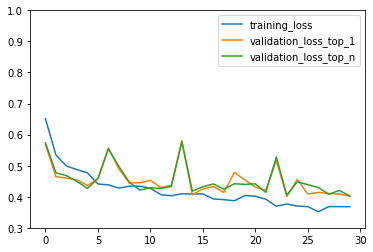

Epoch 31/450
training loss : {0.3609} training_acc : {0.8512} 
5 Fold Validation Accuracy : {0.8213} || 5 Fold Validation Loss : {0.4511}
1 Fold Validation Accuracy : {0.8150} || 1 Fold Validation Loss : {0.4821}
Total Correct Prediction Percentage 77.0% 
Total Correct Prediction Percentage 70.0% 
Epoch 32/450
training loss : {0.3663} training_acc : {0.8492} 
5 Fold Validation Accuracy : {0.8118} || 5 Fold Validation Loss : {0.4186}
1 Fold Validation Accuracy : {0.8094} || 1 Fold Validation Loss : {0.4302}
Total Correct Prediction Percentage 84.0% 
Total Correct Prediction Percentage 74.0% 
Epoch 33/450
training loss : {0.3598} training_acc : {0.8497} 
5 Fold Validation Accuracy : {0.8249} || 5 Fold Validation Loss : {0.3979}
1 Fold Validation Accuracy : {0.8231} || 1 Fold Validation Loss : {0.3985}
Total Correct Prediction Percentage 80.0% 
Total Correct Prediction Percentage 72.0% 
Epoch 34/450
training loss : {0.3643} training_acc : {0.8505} 
5 Fold Validation Accuracy : {0.7915} ||

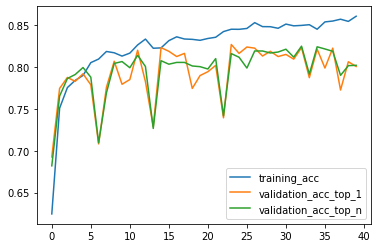

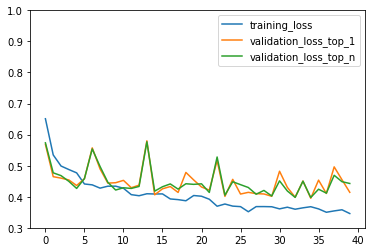

Epoch 41/450
training loss : {0.3413} training_acc : {0.8556} 
5 Fold Validation Accuracy : {0.8121} || 5 Fold Validation Loss : {0.4488}
1 Fold Validation Accuracy : {0.8231} || 1 Fold Validation Loss : {0.4128}
Total Correct Prediction Percentage 83.0% 
Total Correct Prediction Percentage 73.0% 
Epoch 42/450
training loss : {0.3564} training_acc : {0.8496} 
5 Fold Validation Accuracy : {0.7881} || 5 Fold Validation Loss : {0.4786}
1 Fold Validation Accuracy : {0.7906} || 1 Fold Validation Loss : {0.4817}
Total Correct Prediction Percentage 86.0% 
Total Correct Prediction Percentage 75.0% 
Epoch 43/450
training loss : {0.3464} training_acc : {0.8555} 
5 Fold Validation Accuracy : {0.7945} || 5 Fold Validation Loss : {0.4338}
1 Fold Validation Accuracy : {0.7929} || 1 Fold Validation Loss : {0.4351}
Total Correct Prediction Percentage 85.0% 
Total Correct Prediction Percentage 79.0% 
5 Fold Test Accuracy : {0.7241} || 5 Fold Test Loss : {0.5815}
1 Fold Test Accuracy : {0.7260} || 1 Fol

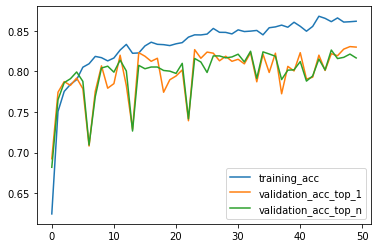

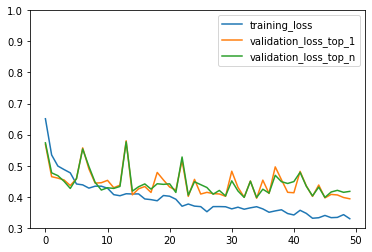

Epoch 51/450
training loss : {0.3366} training_acc : {0.8607} 
5 Fold Validation Accuracy : {0.7868} || 5 Fold Validation Loss : {0.4662}
1 Fold Validation Accuracy : {0.7856} || 1 Fold Validation Loss : {0.4622}
Total Correct Prediction Percentage 84.0% 
Total Correct Prediction Percentage 75.0% 
Epoch 52/450
training loss : {0.3395} training_acc : {0.8607} 
5 Fold Validation Accuracy : {0.7265} || 5 Fold Validation Loss : {0.5991}
1 Fold Validation Accuracy : {0.7219} || 1 Fold Validation Loss : {0.5857}
Total Correct Prediction Percentage 78.0% 
Total Correct Prediction Percentage 75.0% 
Epoch 53/450
training loss : {0.3381} training_acc : {0.8596} 
5 Fold Validation Accuracy : {0.7939} || 5 Fold Validation Loss : {0.4567}
1 Fold Validation Accuracy : {0.7950} || 1 Fold Validation Loss : {0.4634}
Total Correct Prediction Percentage 74.0% 
Total Correct Prediction Percentage 66.0% 
Epoch 54/450
training loss : {0.3462} training_acc : {0.8607} 
5 Fold Validation Accuracy : {0.8089} ||

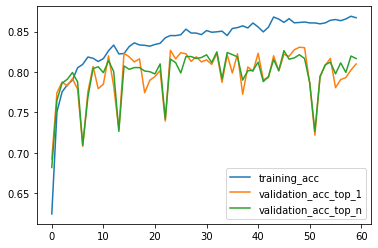

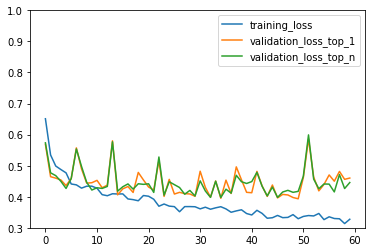

Epoch 61/450
training loss : {0.3158} training_acc : {0.8720} 
5 Fold Validation Accuracy : {0.8274} || 5 Fold Validation Loss : {0.4422}
1 Fold Validation Accuracy : {0.8207} || 1 Fold Validation Loss : {0.4668}
Total Correct Prediction Percentage 79.0% 
Total Correct Prediction Percentage 73.0% 
Epoch 62/450
training loss : {0.3211} training_acc : {0.8694} 
5 Fold Validation Accuracy : {0.8009} || 5 Fold Validation Loss : {0.4899}
1 Fold Validation Accuracy : {0.7956} || 1 Fold Validation Loss : {0.5129}
Total Correct Prediction Percentage 85.0% 
Total Correct Prediction Percentage 76.0% 
Epoch 63/450
training loss : {0.3223} training_acc : {0.8698} 
5 Fold Validation Accuracy : {0.7812} || 5 Fold Validation Loss : {0.4551}
1 Fold Validation Accuracy : {0.7702} || 1 Fold Validation Loss : {0.4889}
Total Correct Prediction Percentage 84.0% 
Total Correct Prediction Percentage 78.0% 
Epoch 64/450
training loss : {0.3253} training_acc : {0.8675} 
5 Fold Validation Accuracy : {0.8266} ||

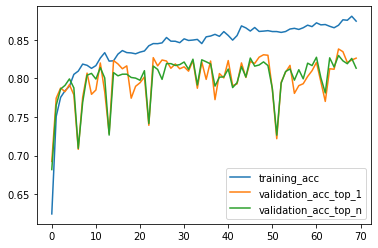

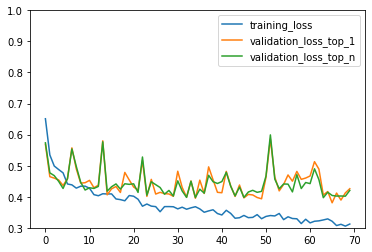

Epoch 71/450
training loss : {0.3183} training_acc : {0.8732} 
5 Fold Validation Accuracy : {0.8190} || 5 Fold Validation Loss : {0.4241}
1 Fold Validation Accuracy : {0.8138} || 1 Fold Validation Loss : {0.4430}
Total Correct Prediction Percentage 79.0% 
Total Correct Prediction Percentage 75.0% 
Epoch 72/450
training loss : {0.3088} training_acc : {0.8768} 
5 Fold Validation Accuracy : {0.8099} || 5 Fold Validation Loss : {0.4520}
1 Fold Validation Accuracy : {0.8094} || 1 Fold Validation Loss : {0.4686}
Total Correct Prediction Percentage 84.0% 
Total Correct Prediction Percentage 78.0% 
Epoch 73/450
training loss : {0.3144} training_acc : {0.8749} 
5 Fold Validation Accuracy : {0.8031} || 5 Fold Validation Loss : {0.4402}
1 Fold Validation Accuracy : {0.8187} || 1 Fold Validation Loss : {0.4168}
Total Correct Prediction Percentage 85.0% 
Total Correct Prediction Percentage 77.0% 
Epoch 74/450
training loss : {0.3219} training_acc : {0.8699} 
5 Fold Validation Accuracy : {0.8288} ||

Exception ignored in: <generator object datagen.train_gen at 0x7f2af0220550>
RuntimeError: generator ignored GeneratorExit


KeyboardInterrupt: 

In [30]:
with tf.device("GPU"):
    training_loss_g= []
    training_accuracy_g = []
    validation_accuracy_g_1 = []
    validation_accuracy_g_n = []
    validation_loss_g_1 = []
    validation_loss_g_n = []
    
    max_train_acc = 0.0
    max_val_acc_1 = 0.0
    max_val_acc_n = 0.0
    best_test_class_acc = 0.0
    best_val_classifier = 0.0
    epochs =  450
    for epoch in range(1,epochs+1):
        print("Epoch {}/{}".format(epoch,epochs))
        total_samples = 0
        total_correct = 0.0
        running_loss = 0.0
        batch_ = 0
        for x,y in gen.train_gen():
            batch_ += 1
            met = model.train_on_batch(x,y)
            y_pred = model.predict(x)
            y_pred = np.argmax(y_pred,axis = 1)
            total_samples += x.shape[0]
            total_correct += np.sum(y_pred==y)
            running_loss += met*x.shape[0]
        loss_shown = running_loss/np.float(total_samples)
        accuracy_shown = total_correct/np.float(total_samples)
        training_loss_g.append(loss_shown)
        training_accuracy_g.append(accuracy_shown)
        model.save("/kaggle/working/running_model.h5")
        if accuracy_shown>=max_train_acc:
            max_train_acc = accuracy_shown 
            model.save("/kaggle/working/best_train_acc.h5")
            
        print("training loss : {%.4f} training_acc : {%.4f} "%(loss_shown,accuracy_shown))          
        
        val_acc_n,val_loss_n = n_fold_accuracy(model,gen,5,"val")
        validation_accuracy_g_n.append(val_acc_n)
        validation_loss_g_n.append(val_loss_n)
        
        if max_val_acc_n <=val_acc_n:
            max_val_acc_n = val_acc_n
            model.save("/kaggle/working/best_val_acc_n.h5")
            
        
        val_acc_1,val_loss_1 = n_fold_accuracy(model,gen,1,"val")
        validation_accuracy_g_1.append(val_acc_1)
        validation_loss_g_1.append(val_loss_1)

        if max_val_acc_1 <=val_acc_1:
            max_val_acc_1 = val_acc_1
            model.save("/kaggle/working/best_val_acc_1.h5")

        best_val_class=val_videos_acc(model,gen)
        if best_val_classifier<=best_val_class:
            best_val_classifier = best_val_class
            model.save("/kaggle/working/best_val_classifier.h5")
        
        
        test_class_acc = test_videos_acc(model,gen)
        
        if best_test_class_acc<=test_class_acc:
            best_test_class_acc = test_class_acc
            n_fold_accuracy(model,gen,5,"test")
            n_fold_accuracy(model,gen,1,"test")
            model.save("/kaggle/working/best_classifier.h5")
            
        np.save("/kaggle/working/training_loss_g.npy",training_loss_g,allow_pickle = True)
        np.save("/kaggle/working/training_accuracy_g.npy",training_accuracy_g,allow_pickle = True)
        np.save("/kaggle/working/validation_accuracy_g_1.npy",validation_accuracy_g_1,allow_pickle = True)
        np.save("/kaggle/working/validation_accuracy_g_n.npy",validation_accuracy_g_n,allow_pickle = True)
        np.save("/kaggle/working/validation_loss_g_n.npy",validation_loss_g_n,allow_pickle = True)
        np.save("/kaggle/working/validation_loss_g_1.npy",validation_loss_g_1,allow_pickle = True)
        model_state = {
            "max_acc":max_train_acc,
            "max_val_acc_1":max_val_acc_1,
            "max_val_acc_n":max_val_acc_n,
            "best_test_class_acc":best_test_class_acc,
            "best_val_classifier":best_val_classifier,
            "epoch":epoch
        }
        np.save("/kaggle/working/model_state.npy",model_state,allow_pickle = True)


        if epoch%10==0:
            #n_fold_accuracy(model,gen,5,"test")
            #n_fold_accuracy(model,gen,1,"test")
            print("\n")
            try:
                plt.plot(training_accuracy_g,label = "training_acc")
                plt.plot(validation_accuracy_g_1,label = "validation_acc_top_1")
                plt.plot(validation_accuracy_g_n,label = "validation_acc_top_n")
                plt.legend()
                plt.show()
                plt.plot(training_loss_g,label = "training_loss")
                plt.plot(validation_loss_g_1,label = "validation_loss_top_1")
                plt.plot(validation_loss_g_n,label = "validation_loss_top_n")
                plt.ylim(0.3,1)
                plt.legend()
                plt.show()
            except:
                pass
            

In [ ]:
validation_loss_g_n = validation_loss_g_n[:-2]s